In [1]:
import time
import json
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# nlp libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [8]:
# data_list = []

# with open('goodreads_reviews_spoiler.json', 'r') as file:
#     for line in file:
#         data_list.append(json.loads(line))

# # convert to pandas dataframe
# df = pd.DataFrame(data_list)

# df.to_csv('goodreads_reviews_spoiler.csv', index=False)

In [47]:
df = pd.read_csv('goodreads_reviews_spoiler.csv')
df.head()

,user_id,timestamp,rating,has_spoiler,book_id,review_id,review_text
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,This is a special book. It started slow for ab...
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,3,False,16981,a5d2c3628987712d0e05c4f90798eb67,Recommended by Don Katz. Avail for free in Dec...
2,8842281e1d1347389f2ab93d60773d4d,2017-03-20,3,True,28684704,2ede853b14dc4583f96cf5d120af636f,"A fun, fast paced science fiction thriller. I ..."
3,8842281e1d1347389f2ab93d60773d4d,2016-11-09,0,False,27161156,ced5675e55cd9d38a524743f5c40996e,Recommended reading to understand what is goin...
4,8842281e1d1347389f2ab93d60773d4d,2016-04-25,4,True,25884323,332732725863131279a8e345b63ac33e,"I really enjoyed this book, and there is a lot..."


### 1. Data Preprocessing

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# function to flatten the clolumns "review_sentences" which has nested lists
def flatten_review_sentences(review_sentences):
    # convert string representation of list to an actual list
    sentences = ast.literal_eval(review_sentences)
    # extract the text from each inner list and concatenate them
    flattened_text = ' '.join([sentence[1] for sentence in sentences])
    return flattened_text

df['review_text'] = df['review_sentences'].apply(flatten_review_sentences)
df = df.drop(columns=['review_sentences'])

In [11]:
# # checking for missing values
# df.isna().sum()

### 2. Feature Engineering

In [12]:
df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))
# a binary feature for short reviews
df['is_short_review'] = df['review_length'] < 200

### 3. EDA

In [14]:
print(f"There are {df['book_id'].nunique()} books and {df['user_id'].nunique()} users in ur data.")

There are 25475 books and 18892 users in ur data.


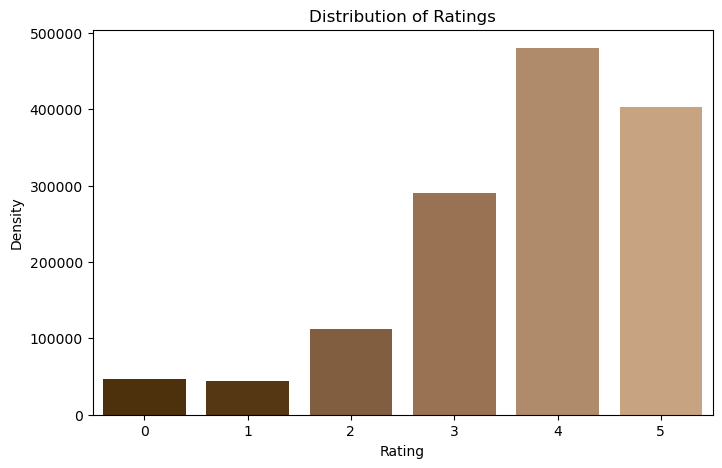

In [27]:
colors = ['#583101', '#603808', '#8B5E34', '#A47148', '#BC8A5F', '#D4A276', '#E7BC91', '#F3D5B5','#fffae5','#fff6cc','#fff2b2','#ffee99','#ffe97f','#ffe566','#ffe14c','#ffdd32','#ffd819','#ffd400', '#ffc300', '#ffb700']

plt.figure(figsize=(8, 5))
sns.barplot(x=df['rating'].value_counts().index, y=df['rating'].value_counts().values, palette=colors)
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution of Ratings')
plt.show()

The ratings are distributed across the scale from 0 to 5, with 4 and 5 ratings more frequent than others.

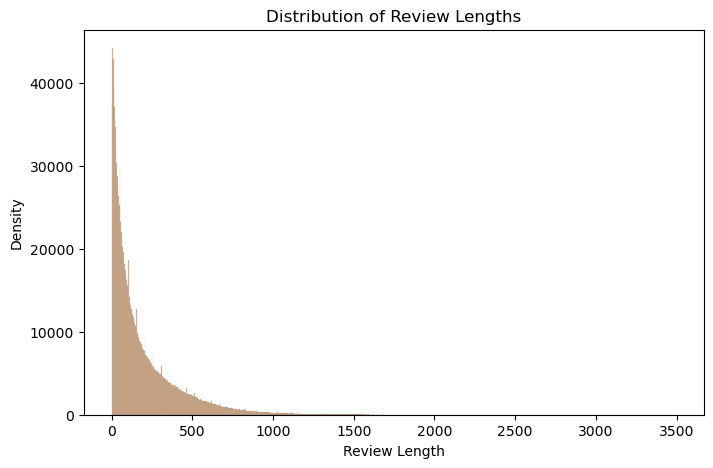

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="review_length", color='#D4A276') 
plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths')
plt.show()

In [43]:
short_reviews_percentage = (df['review_length'] < 200).mean() * 100
print(f"Percentage of reviews with length < 200: {short_reviews_percentage:.2f}%")

Percentage of reviews with length < 200: 66.99%


The plot shows that approx. 67% of the reviews have a length lower than 200 words, which indicates that the majority of reviews are relatively short. 

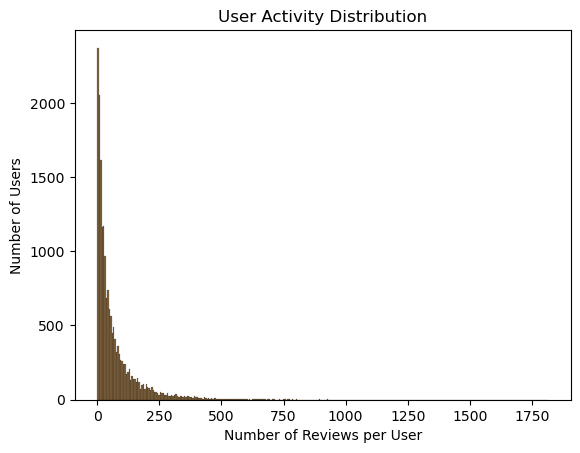

In [17]:
user_activity = df['user_id'].value_counts()
sns.histplot(user_activity, kde=False, color='#583101')
plt.title('User Activity Distribution')
plt.xlabel('Number of Reviews per User')
plt.ylabel('Number of Users')
plt.show()

The distribution shows that most users have written a very small number of reviews and a large portion of the reviews come from a small number of highly active users.

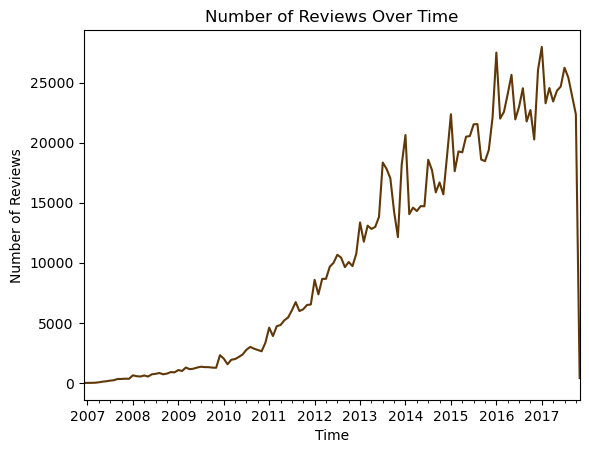

In [18]:
df.set_index('timestamp', inplace=True)

df.resample('M').size().plot(color='#603808')
plt.title('Number of Reviews Over Time')
plt.ylabel('Number of Reviews')
plt.xlabel('Time')
plt.show()

Around 2012, there was a significant increase in the number of reviews, followed by periodic fluctuations.
The overall trend shows an increase in the number of reviews over time, reflecting growing user engagement on the platform.

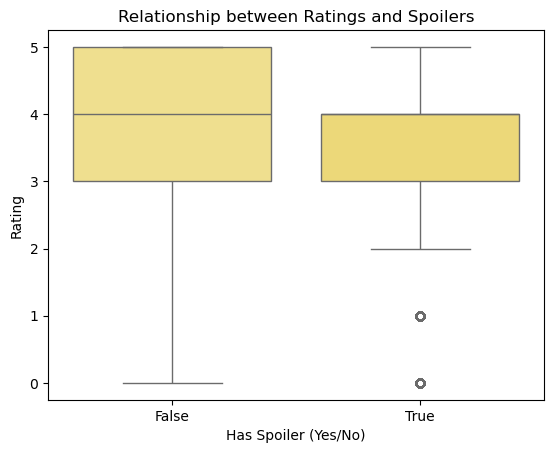

In [35]:
sns.boxplot(
    x="has_spoiler",
    y="rating",
    data=df,
    palette=['#ffe97f','#ffe566','#ffe14c',],
)
plt.xlabel('Has Spoiler (Yes/No)')
plt.ylabel('Rating')
plt.title('Relationship between Ratings and Spoilers')
plt.show()

The box plot shows that reviews without spoilers have higher ratings and reviews with spoilers tend to have lower ratings, with notable outliers in the 0-1 range.

### 4. Text Preprocessing

In [38]:
# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

# function for text preprocessing
def preprocess_text(text):
    # tokenize the text
    tokens = word_tokenize(text)
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    # remove punctuation and stop words, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

df['processed_review_text_NLTK'] = df['review_text'].apply(preprocess_text)
df[['review_text', 'processed_review_text_NLTK']].head()

,review_text,processed_review_text_NLTK
0,This is a special book. It started slow for ab...,special book started slow first third middle t...
1,Recommended by Don Katz. Avail for free in Dec...,recommended katz avail free december http
2,"A fun, fast paced science fiction thriller. I ...",fun fast paced science fiction thriller read 2...
3,Recommended reading to understand what is goin...,recommended reading understand going middle am...
4,"I really enjoyed this book, and there is a lot...",really enjoyed book lot recommend drag little ...


In [39]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function for text preprocessing
def preprocess_text(text):
    # tokenize the text
    doc = nlp(text)
    
    # lemmatize the tokens and convert to lowercase
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space]
    
    # remove stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]
    
    return ' '.join(tokens)

df['processed_review_text_SPACY'] = df['review_text'].apply(preprocess_text)
df[['review_text', 'processed_review_text_SPACY']].head()

,review_text,processed_review_text_SPACY
0,This is a special book. It started slow for ab...,special book start slow middle start interesti...
1,Recommended by Don Katz. Avail for free in Dec...,recommend don katz avail free december http://...
2,"A fun, fast paced science fiction thriller. I ...",fun fast pace science fiction thriller read 2 ...
3,Recommended reading to understand what is goin...,recommend reading understand middle america po...
4,"I really enjoyed this book, and there is a lot...",enjoy book lot recommend drag little end knock...


In [40]:
# save the processed data for further analysis
df.to_csv('processed_data.csv', index=False)